In [19]:
import sagemaker
import pandas as pd
from time import strftime,gmtime

In [3]:
session=sagemaker.Session()
role=sagemaker.get_execution_role()
sagemaker.__version__

'2.31.1'

In [8]:
algo='linear-learner'
datasetname='boston'
datadir='data-boston'
container=sagemaker.image_uris.retrieve(algo,session.boto_region_name,version='latest')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


In [9]:
project=f'my-{algo}-{datasetname}'

In [10]:
mymodel=sagemaker.estimator.Estimator(image_uri=container,
                                      role=role,
                                      instance_count=1,
                                      instance_type='ml.m5.large',
                                      base_job_name=project,
                                      use_spot_instances=True,
                                      max_run=3600,
                                      max_wait=3600                                      

)

In [11]:
mymodel.set_hyperparameters(predictor_type='regressor',
                            loss='squared_loss',
                           num_models=1,
                           epochs=5,
                           mini_batch_size=100,
                           normalize_data=True)

# mymodel.set_hyperparameters(max_depth=5,
#                        eta=0.2,
#                        gamma=4,
#                        min_child_weight=6,
#                        subsample=0.8,
#                        objective='reg:linear',
#                        early_stopping_rounds=10,
#                        num_round=200)

In [15]:
s3_input_train=sagemaker.inputs.TrainingInput(s3_data='s3://sagemaker-us-east-1-032934527328/boston-xgboost-HL/train.csv',
                                  content_type='text/csv')
s3_input_validation=sagemaker.inputs.TrainingInput(s3_data='s3://sagemaker-us-east-1-032934527328/boston-xgboost-HL/validation.csv',
                                  content_type='text/csv')

In [16]:
mymodel.fit({'train':s3_input_train,'validation':s3_input_validation})

2021-04-16 12:56:14 Starting - Starting the training job...
2021-04-16 12:56:18 Starting - Launching requested ML instancesProfilerReport-1618577774: InProgress
......
2021-04-16 12:57:31 Starting - Preparing the instances for training......
2021-04-16 12:58:38 Downloading - Downloading input data...
2021-04-16 12:59:11 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script

2021-04-16 12:59:41 Uploading - Uploading generated training model
2021-04-16 12:59:41 Completed - Training job completed
[04/16/2021 12:59:30 INFO 140231357097792] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samp

Training seconds: 63
Billable seconds: 26
Managed Spot Training savings: 58.7%


In [17]:
mymodel_transformer=mymodel.transformer(instance_count=1,
                                        instance_type='ml.m5.large',
                                        model_name=project)

In [20]:
mymodel_transformer.transform('s3://sagemaker-us-east-1-032934527328/boston-xgboost-HL/test.csv',
                                  content_type='text/csv',
                              split_type='Line',
                              job_name=project+strftime("%Y-%m-%d-%H-%M-%S", gmtime()))

...........................
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[04/16/2021 13:04:58 INFO 140366809696064] loaded entry point class algorithm.serve.server_config:config_api
[04/16/2021 13:04:58 INFO 140366809696064] loading entry points
[04/16/2021 13:04:58 INFO 140366809696064] loaded request iterator application/json
[04/16/2021 13:04:58 INFO 140366809696064] loaded request iterator application/jsonlines
[04/16/2021 13:04:58 INFO 140366809696064] loaded request iterator application/x-recordio-protobuf
[04/16/2021 13:04:58 INFO 140366809696064] loaded request iterator text/csv
[04/16/2021 13:04:58 INFO 140366809696064] loaded response encoder application/json
[04/16/2021 13:04:58 INFO 140366809696064] loaded response encoder application/jsonlines
[04/16/2021 13:04:58 INFO 140366809696064] loaded response encoder application/x-recordio-protobuf
[04/16/2021 13:04:58 INFO 140366809696064] loaded response encoder text/csv
[04/1

In [21]:
!aws s3 cp  $mymodel_transformer.output_path/test.csv.out data-boston/
!aws s3 cp  s3://sagemaker-us-east-1-032934527328/boston-xgboost-HL/y_test.csv data-boston/

download: s3://sagemaker-us-east-1-032934527328/my-linear-learner-boston2021-04-16-13-00-37/test.csv.out to data-boston/test.csv.out
download: s3://sagemaker-us-east-1-032934527328/boston-xgboost-HL/y_test.csv to data-boston/y_test.csv


In [22]:
y_pred=pd.read_csv('data-boston/test.csv.out',header=None)
y_pred

,0
0,"{""score"":18.7191162109375}"
1,"{""score"":23.232467651367188}"
2,"{""score"":26.461427688598633}"
3,"{""score"":23.728721618652344}"
4,"{""score"":19.271286010742188}"
...,...
162,"{""score"":22.827392578125}"
163,"{""score"":24.679758071899414}"
164,"{""score"":21.017541885375977}"
165,"{""score"":22.3370361328125}"


In [23]:
import json
y_pred=[json.loads(r)['score'] for r in y_pred[0]]
y_test=pd.read_csv('data-boston/y_test.csv',header=None)

In [24]:
from time import strftime,gmtime
from matplotlib import pyplot as plt

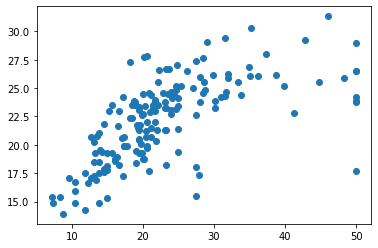

In [27]:
plt.scatter(y_test,y_pred)

In [58]:
import os
import tarfile
import numpy as np
import mxnet as mx

In [42]:
job_name = mymodel.latest_training_job.job_name
model_fname = 'model.tar.gz'
model_object = 's3://'+session.default_bucket()+'/'+os.path.join(mymodel.latest_training_job.job_name, 'output', model_fname)

In [44]:
!aws s3 cp  $model_object data-boston/

download: s3://sagemaker-us-east-1-032934527328/my-linear-learner-boston-2021-04-16-12-56-14-552/output/model.tar.gz to data-boston/model.tar.gz


In [48]:
with tarfile.open('data-boston/model.tar.gz') as tar:
    tar.extractall()
print('Downloaded and extracted model tarball: {}'.format(model_object))

Downloaded and extracted model tarball: s3://sagemaker-us-east-1-032934527328/my-linear-learner-boston-2021-04-16-12-56-14-552/output/model.tar.gz


In [61]:
model_list = [fname for fname in os.listdir('data-boston/') if fname.startswith('model_')]
model_fname = model_list[0]
print('Found model file: {}'.format(model_fname))

Found model file: model_algo-1


In [69]:
with open('data-boston/mx-mod-0000.params','rb') as f:
    readfile=f.read()

In [73]:
# load the json file
import json
sym_json = json.load(open('data-boston/mx-mod-symbol.json'))
sym_json_string = json.dumps(sym_json)

# open model
import mxnet as mx
from mxnet import gluon
net = gluon.nn.SymbolBlock(
        outputs=mx.sym.load_json(sym_json_string),
        inputs=mx.sym.var('data'))

# params file
net.load_parameters('data-boston/mx-mod-0000.params', allow_missing=True)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/mxnet/gluon/block.py:1591: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


In [93]:
type(net.collect_params().get('fc0_weight'))

mxnet.gluon.parameter.Parameter

In [94]:
net.collect_params().get('fc0_weight').data()


[[-4.0374890e-02]
 [ 2.3525482e-02]
 [-2.4695231e-02]
 [ 3.9365187e+00]
 [-2.5768225e+00]
 [ 1.2963154e+00]
 [-1.3769929e-02]
 [ 3.5799712e-01]
 [-6.3028522e-02]
 [-1.7766751e-03]
 [-1.2345810e-01]
 [ 3.0137368e-03]
 [-7.5247549e-02]]
<NDArray 13x1 @cpu(0)>

In [95]:
net.collect_params().get('fc0_bias').data()


[[18.68419]]
<NDArray 1x1 @cpu(0)>

In [98]:
net.collect_params().get('out_label').data()

RuntimeError: Parameter 'out_label' has not been initialized. Note that you should initialize parameters and create Trainer with Block.collect_params() instead of Block.params because the later does not include Parameters of nested child Blocks